# This notebook is dedicated to the same as ANTM
But it works only with all of the features and also runs an OLS model (only OLS because I know lasso and ridge won't work)

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score,cross_val_predict

In [2]:
country_data = pd.read_pickle('full_country_data.pkl')


country_data['r_home_war'] = country_data['r_home_war'].astype(float)
#drop data deficit
country_data = country_data.drop(['malnutrition','pov_ind','divorce','homeless','Continent','BothSexes','MalesNumber',
                                 'FemalesNumber','marriage','marr_div_ratio'],axis=1)

X,y = country_data.drop('bc_BothSexes',axis=1), country_data['bc_BothSexes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13,shuffle=True)

In [3]:
X_train['gdp'] = np.log(X_train.gdp)
X_train['total_sex_ratio'] = 1/(X_train.total_sex_ratio)
X_train['guns'] = np.log(X_train.guns+1)
X_train['doc_ratio'] = np.log(X_train.doc_ratio)
X_train['pop_dens'] = np.log(X_train.pop_dens)
X_train['elevation'] = np.log(X_train.elevation)
X_train['immigrants'] = np.log(X_train.immigrants)
X_train['literacy'] = (X_train.literacy)**1/2
X_train['gdppp'] = np.log(X_train.gdppp)
X_train['population'] = np.log(X_train.population)
X_train['children'] = X_train.children**2
X_train['below_pov_line'] = np.log(X_train.below_pov_line)
X_train['wine'] = np.log(X_train.wine+1)
X_train['oth_alc'] = np.log(X_train.oth_alc+1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [4]:
def validate_OLS(feature_matrix,target_series) :
    """
    does a k_fold validation on a potential model to determine the average adj_r2 of each validation
    
    args:
        target_series = series of dependent variable
        feature_matrix = pd.DataFrame of predictors
    returns :
        mean adjusted r2 (maybe with list of features, undecided) for that model; float
        
    IMPORTANT NOTE : with smaller data sets, you will get weird results (aka negative adj_R2); the value
    does still increase as the model improves though, so it should not be a problem long term.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state = 8)
    r2s = cross_val_score(LinearRegression(), feature_matrix, target_series, cv=kf, scoring='r2')
    return np.mean(r2s)

In [5]:
def high_corr_check(feature_matrix,target_series,max_corr) :
        """
    looks for any remaining high correlations and so that they can be looked at logically 
    
    args:
        target_series = np.series of dependent variable
        feature_matrix = pd.DataFrame of predictors
        max_corr = maximum correlation allowed between any two features (float; 0<max_corr<1)
    returns :
        list of highly (maybe with list of features, undecided) for that model
        
    """
        start_adj_r2 = validate_OLS(feature_matrix,target_series)
        high_corrs = []
        for col1 in feature_matrix.columns :
            for col2 in feature_matrix.columns :
                if col1 != col2 :
                    corr = np.corrcoef(feature_matrix[col1],feature_matrix[col2])[0][1]
                    if (abs(corr) >= max_corr and (col2, col1, corr) not in high_corrs): #not in is not working
                        high_corrs.append((col1,col2,corr))
        return list(set(high_corrs))

In [6]:
whole_train = pd.concat([y_train,X_train],axis=1)

In [7]:
'+'.join(list(whole_train.columns))

'bc_BothSexes+happy+doc_ratio+below_pov_line+gdp+gdppp+unemp+med_age+med_age_male+med_age_female+birth_sex_ratio+total_sex_ratio+literacy+hum_freedom+econ_freedom+gen_inequality+sunny_hours+rainfall+pop_dens+avg_temp+int_users+eth_div+ling_div+relig_div+wto+alc_cons+beer+wine+spirits+oth_alc+total_bmi+fem_bmi+male_bmi+r_home_war+elevation+guns+farmers+depression+children+urbanization+immigrants+population+homeless_dummy+marr_div_dummy+malnutrition_dummy+pov_ind_dummy'

In [8]:
whole_train=whole_train.drop(['gen_inequality','children','gdppp','med_age','med_age_male','male_bmi',
                             'birth_sex_ratio','hum_freedom','econ_freedom','rainfall','fem_bmi','homeless_dummy',
                             'marr_div_dummy','malnutrition_dummy','pov_ind_dummy','population','wto'],axis=1,
                             errors='ignore')

In [9]:
lregmodel = smf.ols("""bc_BothSexes ~ happy+doc_ratio+below_pov_line+gdp+unemp+med_age_female+total_sex_ratio+literacy+sunny_hours+pop_dens+avg_temp+int_users+eth_div+ling_div+relig_div+alc_cons+beer+wine+spirits+oth_alc+total_bmi+r_home_war+elevation+guns+farmers+depression+urbanization+immigrants"""
                     ,data=whole_train)
results = lregmodel.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           bc_BothSexes   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     5.150
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           1.36e-10
Time:                        16:14:17   Log-Likelihood:                -207.76
No. Observations:                 146   AIC:                             473.5
Df Residuals:                     117   BIC:                             560.0
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.1320      3.443      2.653      0.009       2.314      15.950
happy               0.1213      0.145      0.836      0.405      -0.166       0.408
doc_ratio          -0.2806      0.178     -1.580      0.117      -0.632       0.071
below_pov_line     -0.1374      0.166     -0.830      0.408      -0.465       0.191
gdp                 0.0050      0.075      0.066      0.947      -0.143       0.153
unemp              -0.0059      0.019     -0.305      0.761      -0.044       0.032
med_age_female      0.0252      0.029      0.868      0.387      -0.032       0.083
total_sex_ratio     1.4682      1.740      0.844      0.401      -1.979       4.915
literacy           -0.0256      0.021     -1.220      0.225      -0.067       0.016
sunny_hours        -0.0005      0.000     -1.702      0.091      -0.001    8.19e-05
pop_dens           -0.1219      0.091     -1.346      0.181      -0.301       0.057
avg_temp           -0.0601      0.020     -2.966      0.004      -0.100      -0.020
int_users          -0.0281      0.010     -2.927      0.004      -0.047      -0.009
eth_div             0.5394      0.585      0.922      0.358      -0.619       1.698
ling_div           -0.3300      0.550     -0.600      0.550      -1.420       0.760
relig_div          -0.1054      0.508     -0.207      0.836      -1.112       0.902
alc_cons            0.0959      0.036      2.665      0.009       0.025       0.167
beer                0.0096      0.007      1.470      0.144      -0.003       0.023
wine               -0.1559      0.120     -1.296      0.198      -0.394       0.082
spirits             0.0065      0.007      0.909      0.365      -0.008       0.021
oth_alc             0.2774      0.127      2.180      0.031       0.025       0.529
total_bmi          -0.0701      0.078     -0.897      0.372      -0.225       0.085
r_home_war         -0.3293      0.298     -1.103      0.272      -0.920       0.262
elevation          -0.1726      0.117     -1.471      0.144      -0.405       0.060
guns                0.0379      0.139      0.273      0.785      -0.237       0.313
farmers            -0.0103      0.008     -1.244      0.216      -0.027       0.006
depression         -0.0008      0.001     -1.205      0.231      -0.002       0.001
urbanization        0.0124      0.008      1.605      0.111      -0.003       0.028
immigrants          0.0346      0.096      0.361      0.719      -0.155       0.224
==============================================================================
Omnibus:                        3.005   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.223   Jarque-Bera (JB):                2.494
Skew:                           0.271   Prob(JB):                        0.287
Kurtosis:                       3.342   Cond. No.                     1.04e+05


# Now to start feature combining

In [10]:
X_train = X_train.drop(['gen_inequality','children','gdppp','med_age','med_age_male','male_bmi',
                        'birth_sex_ratio','hum_freedom','econ_freedom','rainfall','fem_bmi','homeless_dummy',
                        'marr_div_dummy','malnutrition_dummy','pov_ind_dummy','population','wto'],axis=1,errors='ignore')

In [11]:
whole_train_t=deepcopy(whole_train)

In [12]:
whole_train_t['t_doc_lit'] = whole_train_t.doc_ratio * whole_train_t.literacy
whole_train_t = whole_train_t.drop(['doc_ratio','literacy'],axis=1)

In [13]:
whole_train_t['t_temp_sunny'] = whole_train_t.avg_temp * whole_train_t.sunny_hours
whole_train_t = whole_train_t.drop(['avg_temp','sunny_hours'],axis=1)

In [14]:
whole_train_t = whole_train_t.drop(['beer','wine','spirits','oth_alc','ling_div','med_age_female','r_home_war',
                                    'unemp','below_pov_line','gdp','eth_div','relig_div','immigrants','urbanization',
                                    'guns','happy','total_sex_ratio'],axis=1)

In [15]:
'+'.join(list(whole_train_t.columns))

'bc_BothSexes+pop_dens+int_users+alc_cons+total_bmi+elevation+farmers+depression+t_doc_lit+t_temp_sunny'

In [16]:
lregmodel = smf.ols("""bc_BothSexes ~ pop_dens+int_users+alc_cons+total_bmi+elevation+farmers+depression+t_doc_lit+t_temp_sunny"""
                     ,data=whole_train_t)
results = lregmodel.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           bc_BothSexes   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     13.09
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           6.83e-15
Time:                        16:14:19   Log-Likelihood:                -220.85
No. Observations:                 146   AIC:                             461.7
Df Residuals:                     136   BIC:                             491.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.2308      1.855      7.132      0.000       9.562      16.899
pop_dens        -0.2204      0.074     -2.979      0.003      -0.367      -0.074
int_users       -0.0131      0.007     -1.905      0.059      -0.027       0.000
alc_cons         0.1372      0.031      4.470      0.000       0.077       0.198
total_bmi       -0.1331      0.060     -2.228      0.028      -0.251      -0.015
elevation       -0.2443      0.106     -2.296      0.023      -0.455      -0.034
farmers         -0.0130      0.008     -1.712      0.089      -0.028       0.002
depression      -0.0016      0.001     -2.705      0.008      -0.003      -0.000
t_doc_lit       -0.0076      0.003     -2.393      0.018      -0.014      -0.001
t_temp_sunny  -2.57e-05   6.25e-06     -4.110      0.000   -3.81e-05   -1.33e-05
==============================================================================
Omnibus:                        1.142   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.565   Jarque-Bera (JB):                0.935
Skew:                           0.195   Prob(JB):                        0.627
Kurtosis:                       3.043   Cond. No.                     1.06e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
lr = LinearRegression()
np.mean(cross_val_score(lr,whole_train_t.iloc[:,1:],whole_train_t.iloc[:,0],scoring='r2'))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.348846019004694

# Having gotten the best possible result through many iterations
Time to try it on the test!

In [18]:
X_test_eng_t = deepcopy(X_test)

X_test_eng_t['gdp'] = np.log(X_test_eng_t.gdp)
X_test_eng_t['total_sex_ratio'] = 1/(X_test_eng_t.total_sex_ratio)
X_test_eng_t['guns'] = np.log(X_test_eng_t.guns+1)
X_test_eng_t['doc_ratio'] = np.log(X_test_eng_t.doc_ratio)
X_test_eng_t['pop_dens'] = np.log(X_test_eng_t.pop_dens)
X_test_eng_t['elevation'] = np.log(X_test_eng_t.elevation)
X_test_eng_t['immigrants'] = np.log(X_test_eng_t.immigrants)
X_test_eng_t['literacy'] = (X_test_eng_t.literacy)**1/2
X_test_eng_t['gdppp'] = np.log(X_test_eng_t.gdppp)
X_test_eng_t['population'] = np.log(X_test_eng_t.population)
X_test_eng_t['children'] = X_test_eng_t.children**2
X_test_eng_t['below_pov_line'] = np.log(X_test_eng_t.below_pov_line)
X_test_eng_t['wine'] = np.log(X_test_eng_t.wine+1)
X_test_eng_t['oth_alc'] = np.log(X_test_eng_t.oth_alc+1)

X_test_eng_t['t_doc_lit'] = X_test_eng_t.doc_ratio * X_test_eng_t.literacy
X_test_eng_t = X_test_eng_t.drop(['doc_ratio','literacy'],axis=1)
X_test_eng_t['t_temp_sunny'] = X_test_eng_t.avg_temp * X_test_eng_t.sunny_hours
X_test_eng_t = X_test_eng_t.drop(['avg_temp','sunny_hours'],axis=1)

X_test_eng_t = X_test_eng_t.loc[:,['pop_dens','int_users','alc_cons','total_bmi','elevation','farmers','depression',
                                  't_doc_lit','t_temp_sunny']]

In [20]:
final_X_train = whole_train_t.iloc[:,1:]
final_y_train = whole_train_t.iloc[:,0]

In [21]:
lm_ols = LinearRegression()
results = lm_ols.fit(final_X_train,final_y_train)

predict = lm_ols.predict(X_test_eng_t)

In [25]:
from scipy.special import inv_boxcox

y_test = inv_boxcox(y_test,[.41719220590443856])
predict = inv_boxcox(predict,[.41719220590443856])

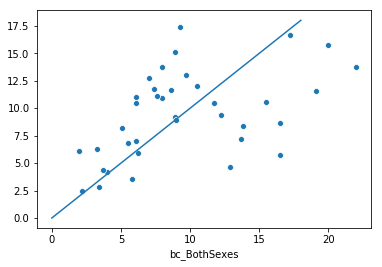

In [30]:
sns.scatterplot(y_test,predict)
plt.plot([0,18],[0,18])

# Ça ç'est pas amélioré. Dommage.